https://nbviewer.ipython.org/github/EL-BID/urbanpy/blob/master/notebooks/Market%20Facility%20Location%20with%20Python.ipynb

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append('..')
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx
import shapely
import numpy as np
import re
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pulp import *
import urbanpy as up

In [3]:
import os

In [4]:
os.listdir()

['.git',
 '.gitignore',
 'Facilites Location.ipynb',
 'inputs',
 'README.md',
 'outputs',
 '.ipynb_checkpoints',
 'ModelProcess.ipynb',
 'LRP test.ipynb',
 'Preprocessing.ipynb']

## Creating candidates set

In [6]:
# Read geojson files
rest = gpd.read_file('outputs/clean_restaurants.geojson')
market = gpd.read_file('outputs/clean_markets.geojson')
survey = gpd.read_file('outputs/clean_surveys.geojson')

In [7]:
# Column headers lower case
rest.columns = map(str.lower, rest.columns)
market.columns = map(str.lower, market.columns)

### Restaurantes

In [8]:
#for i in rest.columns:
#    print(i)

In [9]:
# Obtain latitude and longitude values
rest_gdf = rest
rest_gdf['lat'] = rest_gdf.geometry.centroid.y
rest_gdf['lon'] = rest_gdf.geometry.centroid.x

In [10]:
# Create restaurants candidates set
candidates_rest = rest_gdf[['lat','lon']]
# Add id
candidates_rest.insert(0, 'id', range(1,1+len(candidates_rest)))
# Add geometry variable
candidates_rest = gpd.GeoDataFrame(candidates_rest, geometry=gpd.points_from_xy(candidates_rest['lon'], candidates_rest['lat']))
candidates_rest.crs = 'EPSG:4326'
# Create area variable
area = np.random.randint(10, 25, candidates_rest.shape[0])
candidates_rest['area'] = area
# Create aforo variable
candidates_rest['aforo'] = (candidates_rest['area'] * 2).apply(np.floor).astype(int)
candidates_rest

,id,lat,lon,geometry,area,aforo
0,1,-12.108754,-77.011467,POINT (-77.01147 -12.10875),10,20
1,2,-12.114219,-77.023333,POINT (-77.02333 -12.11422),11,22
2,3,-12.120952,-77.002601,POINT (-77.00260 -12.12095),16,32
3,4,-12.119318,-77.019118,POINT (-77.01912 -12.11932),10,20
4,5,-12.107970,-77.018928,POINT (-77.01893 -12.10797),17,34
...,...,...,...,...,...,...
613,614,-12.109541,-77.012510,POINT (-77.01251 -12.10954),14,28
614,615,-12.121105,-77.002886,POINT (-77.00289 -12.12110),20,40
615,616,-12.120846,-77.002233,POINT (-77.00223 -12.12085),11,22
616,617,-12.120995,-77.002463,POINT (-77.00246 -12.12100),24,48


### Markets

In [11]:
#for i in market.columns:
#    print(i)

In [12]:
# Obtain latitude and longitude values
mark_gdf = market
mark_gdf['lat'] = rest_gdf.geometry.centroid.y
mark_gdf['lon'] = rest_gdf.geometry.centroid.x

In [13]:
# Create markets candidates set
candidates_mark = mark_gdf[['id','lat','lon']]
# Add geometry variable
candidates_mark = gpd.GeoDataFrame(candidates_mark, geometry=gpd.points_from_xy(candidates_mark['lon'], candidates_mark['lat']))
candidates_mark.crs = 'EPSG:4326'
# Add area variable
candidates_mark.insert(4,'area',mark_gdf['area construida'])
# Create aforo variable
candidates_mark['aforo'] = mark_gdf.apply(
    lambda row: row['area construida']*2 if row['tipo de mercado']=='Minorista' else row['area construida']*5,
    axis=1)
candidates_mark

,id,lat,lon,geometry,area,aforo
0,3282,-12.108754,-77.011467,POINT (-77.01147 -12.10875),620.0,1240.0
1,3323-A,-12.114219,-77.023333,POINT (-77.02333 -12.11422),320.0,640.0
2,3321-A,-12.120952,-77.002601,POINT (-77.00260 -12.12095),200.0,400.0
3,3312,-12.119318,-77.019118,POINT (-77.01912 -12.11932),4880.0,9760.0
4,3318-A,-12.107970,-77.018928,POINT (-77.01893 -12.10797),93.0,186.0
5,3313-B,-12.113171,-77.025252,POINT (-77.02525 -12.11317),230.0,460.0
6,3323,-12.115584,-77.023105,POINT (-77.02310 -12.11558),854.0,1708.0
7,3318,-12.116783,-77.023785,POINT (-77.02378 -12.11678),6680.0,13360.0
8,3313-A,-12.107173,-77.018728,POINT (-77.01873 -12.10717),1200.0,2400.0
9,3320,-12.110933,-77.021303,POINT (-77.02130 -12.11093),3000.0,6000.0


### Restaurants and markets union

In [14]:
# Creation of candidates set
# 618 restaurants
# 14 markets
candidates_list = [candidates_rest,candidates_mark]
candidates_tot = gpd.GeoDataFrame(pd.concat(candidates_list,ignore_index=True),crs=candidates_list[0].crs)
candidates_tot

,id,lat,lon,geometry,area,aforo
0,1,-12.108754,-77.011467,POINT (-77.01147 -12.10875),10.0,20.0
1,2,-12.114219,-77.023333,POINT (-77.02333 -12.11422),11.0,22.0
2,3,-12.120952,-77.002601,POINT (-77.00260 -12.12095),16.0,32.0
3,4,-12.119318,-77.019118,POINT (-77.01912 -12.11932),10.0,20.0
4,5,-12.107970,-77.018928,POINT (-77.01893 -12.10797),17.0,34.0
...,...,...,...,...,...,...
627,3320,-12.110933,-77.021303,POINT (-77.02130 -12.11093),3000.0,6000.0
628,3320-A,-12.117476,-76.997034,POINT (-76.99703 -12.11748),6000.0,12000.0
629,3316,-12.110105,-77.017160,POINT (-77.01716 -12.11011),920.0,1840.0
630,3314,-12.105915,-77.023076,POINT (-77.02308 -12.10592),400.0,800.0


In [15]:
N_CANDIDATES = 10

In [16]:
# Select the N_CANDIDATES biggest candidates
candidates = candidates_tot.sort_values('aforo').tail(N_CANDIDATES)
candidates.shape

(10, 6)

## Creating the demand

In [17]:
# Download district boundaries
surquillo = up.download.nominatim_osm('surquillo')
surquillo.crs = 'EPSG:4326'

<AxesSubplot:>

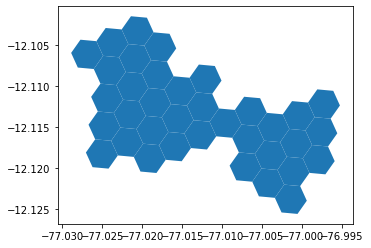

In [18]:
hexagons = up.geom.gen_hexagons(9, surquillo)
hexagons.plot()

In [19]:
lima = up.download.nominatim_osm('Surquillo')
lima

,geometry,place_id,osm_type,osm_id,display_name,place_rank,category,type,importance,icon
0,"POLYGON ((-77.02747 -12.10360, -77.02746 -12.1...",282612435,relation,1944852,"Surquillo, Lima, Lima Metropolitana, Lima, Perú",16,boundary,administrative,0.452242,https://nominatim.openstreetmap.org/ui/mapicon...


In [20]:
a = up.download.overpass_pois(mask=lima,custom_query={'leisure': ['garden', 'pitch']})
a

TypeError: overpass_pois() got an unexpected keyword argument 'mask'

In [21]:
pop = up.download.hdx_dataset('4e74db39-87f1-4383-9255-eaf8ebceb0c9/resource/317f1c39-8417-4bde-a076-99bd37feefce/download/population_per_2018-10-01.csv.zip')

In [22]:
pop_surquillo = up.geom.filter_population(pop, surquillo)

<AxesSubplot:>

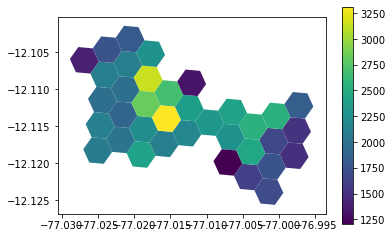

In [24]:
hex_surquillo = up.geom.merge_shape_hex(
    hexagons, 
    pop_surquillo, 
    how='inner', 
    op='intersects', 
    agg={'population_2020': 'sum'}
)

hex_surquillo.plot(column='population_2020', legend=True)

## Distance matrix calculation

In [25]:
up.routing.start_osrm_server('peru', 'south-america', 'foot')

Starting server ...
Server was started succesfully


In [26]:
hex_surq_centroids = hex_surquillo.copy() # Copy original gdf
hex_surq_centroids.geometry = hex_surq_centroids.geometry.centroid # Replace Polygon for Centroid 

In [27]:
try:
    cost_mat = np.load('outputs/distance_matrix.npy')
except:
    distance, duration = up.routing.compute_osrm_dist_matrix(hex_surq_centroids, candidates_market);
    cost_mat = duration.T
    np.save('outputs/distance_matrix.npy', cost_mat) # save the file to avoid running this function again    

In [28]:
up.routing.stop_osrm_server('peru', 'south-america', 'foot')

Server was stoped succesfully


In [29]:
len(cost_mat)

14

## Constructing PuLP sets and variables

In [30]:
#FACILITIES_P = 5
#p = FACILITIES_P + candidates_tot.shape[0]
p = 7

In [31]:
candidates_mark.shape #tot por mark

(14, 6)

In [32]:
customers = list(hex_surq_centroids.index)
facilities = [f'FAC_{i}' for i in candidates_mark.index]

In [33]:
demand = {i: hex_surquillo.loc[i, 'population_2020'] for i in hex_surquillo.index}

In [34]:
cost_dict = {facilities[i]: {customers[j]: cost_mat[i][j] for j in hex_surquillo.index} for i in candidates_mark.index}
#cost_dict

### Create problem variable

In [35]:
from pulp import *

In [36]:
#Create problem variable for PuLP
prob = LpProblem('FLP_Markets_Surquillo', LpMinimize)

In [37]:
#Create the decision variable xij
# % of service assigned from a facility to a customer
# 0 is the lower bound
x = LpVariable.dicts('Service', 
                    [(i,j) for j in customers for i in facilities],
                    0)

In [38]:
# Create decision variable to activate facility yi
y = LpVariable.dicts('Activation',
                     facilities,
                     0,1, LpBinary)

In [39]:
# Objective function
prob += lpSum(lpSum(demand[j]*cost_dict[i][j]*x[i,j] for i in facilities) for j in customers)

In [40]:
# Add first constraint
for j in customers:
    prob += lpSum(x[i,j] for i in facilities) == 1

In [41]:
# Add second constraint
prob += lpSum(y[i] for i in facilities) == p

In [42]:
# Add third constraint
for i in facilities:
    for j in customers:
        prob += x[i,j] <= y[i]

In [43]:
# Solve the problem
prob.solve();

In [44]:
# Check the solution status
print("Status:", LpStatus[prob.status])

Status: Optimal


In [45]:
# Obtain the demand assigments
x_vars = [[0 for j in range(len(customers))] for i in range(len(facilities))]

for v in prob.variables():
    if 'Activation' not in v.name:
        i, j = re.findall('\d+', v.name)
        x_vars[int(i)][int(j)] = v.varValue

In [46]:
y_vars = np.zeros_like(facilities)

for v in prob.variables():
    if 'Activation' in v.name:
        ix = int(re.findall('\d+', v.name)[0])
        y_vars[ix] = v.varValue

y_vars = y_vars.astype(float)

In [47]:
x_vars, y_vars = np.array(x_vars), np.array(y_vars)

In [48]:
print(x_vars.shape, y_vars.shape, candidates_mark.shape)

(14, 36) (14,) (14, 6)


### Save results

In [55]:
# Save facilities information
candidates_mark['is_selected'] = y_vars

df_facilities = candidates_mark
df_facilities['is_not_selected'] = candidates_mark['is_selected']
df_facilities_location = df_facilities[df_facilities.is_not_selected>0]
df_facilities_location.to_csv('outputs/facilities_location.csv', header=True, index=False, encoding='UTF-8')

In [50]:
# Raw
np.save('outputs/assignments.npy', x_vars)
np.save('outputs/facilities.npy', y_vars)

In [52]:
# For viz
candidates.to_file('outputs/facilities', index=False)

## Plotting location of the facilities

In [53]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

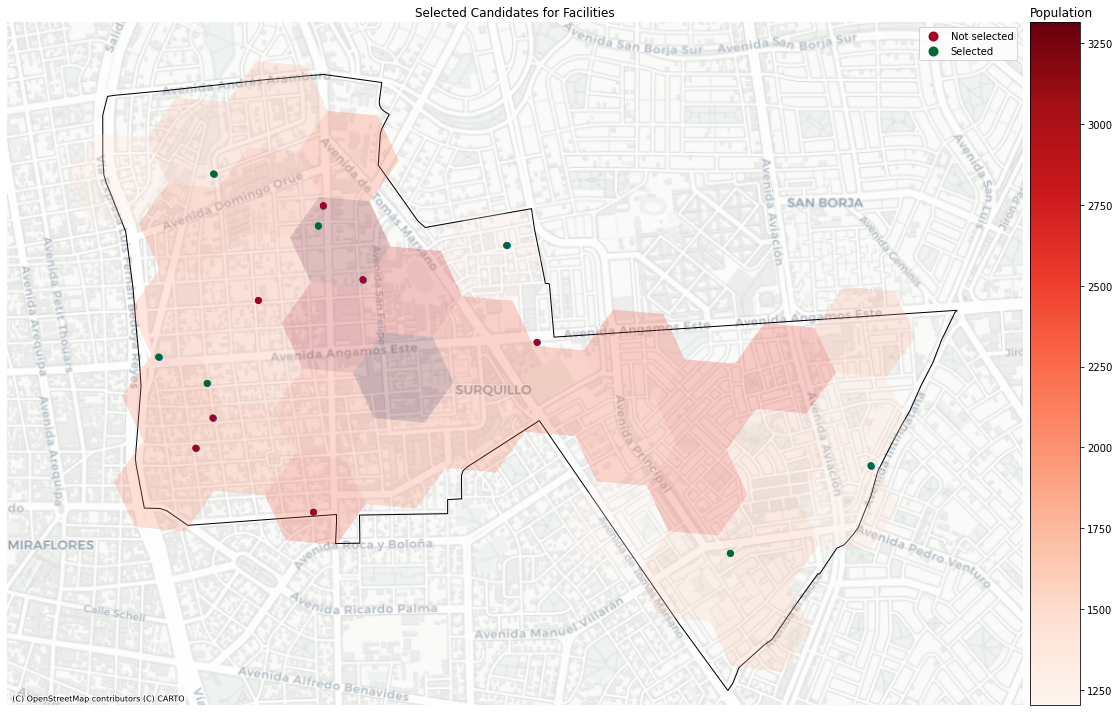

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(40,10))

plt.title('Selected Candidates for Facilities')

# Colorbar for population choropleth map
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cax.set_title('Population', loc='left')

# Administrative boundaries
surquillo.plot(facecolor='none', ax=ax) 
# Population
hex_surquillo.plot('population_2020', cmap='Reds', alpha=0.25, legend=True, ax=ax, cax=cax)
# Current Markets
candidates_mark.plot(ax=ax, legend=True)
candidates_mark.plot('is_selected', legend=True, cmap='RdYlGn', categorical=True, ax=ax) # PoIs

# Format map legend
legend = ax.get_legend()
lines = legend.get_lines()
legend.remove()
markets_legend = Line2D([0], [0], marker='o', color='w', 
                        markerfacecolor='b', markersize=10)
lines.append(markets_legend)
texts = ['Not selected', 'Selected']
ax.legend(lines, texts)

# Set map limits
minx, miny, maxx, maxy = candidates_mark.total_bounds
margins = 0.006
ax.set_xlim(minx-margins, maxx+margins)
ax.set_ylim(miny-margins, maxy+margins)

# Add a basemap
ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs='EPSG:4326')

plt.tight_layout()
